# TFT model

## Preparing the data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

train = pd.read_csv('../../data/processed-data/train_data.csv')
test = pd.read_csv('../../data/processed-data/test_data.csv')

In [ ]:
data = pd.concat([train, test], axis=0)

data_wide = data.pivot(
    index='date',
    columns='symbol',
    values=[
        'open',
        'high',
        'low',
        'close',
        'volume',
        'daily_variation',
        'daily_return',
        '7day_SMA',
        '7day_STD',
        '30day_SMA',
        '30day_STD',
        '7day_WMA',
        '30day_WMA',
        '7day_EMA',
        '30day_EMA',
        'momentum',
        'MACD',
        'MACD_signal',
        'MACD_hist',
        'RSI',
        'slowk',
        'slowd'
    ]
)

data_wide.index = pd.to_datetime(data_wide.index)
data_wide = data_wide.sort_index()
data_wide.head()

open                                                      \
symbol            BP    CL1       CVX   EQNR    NG1        OXY      SHEL   
date                                                                       
2009-11-26       NaN  77.80       NaN    NaN  5.131        NaN       NaN   
2009-11-27  56.71001    NaN  77.63000  24.56    NaN  77.364289  59.48000   
2009-11-30  57.03000  76.05  77.85001  24.61  5.184  77.479409  59.74001   
2009-12-01  58.32001  77.35  79.10001  25.17  4.820  78.678484  60.57001   
2009-12-02  58.53999  77.90  78.99001  25.56  4.682  78.668882  61.00999   

                          high         ...      slowk                 slowd  \
symbol           XOM        BP    CL1  ...       SHEL        XOM         BP   
date                                   ...                                    
2009-11-26       NaN       NaN  77.94  ...        NaN        NaN        NaN   
2009-11-27  74.64999  58.38800    NaN  ...  49.827837  73.343674  56.673127   
2009-11-30  74.49001  57.59000  78.00  ...  51.255367  69.774100  57.830492   
2009-12-01  76.00000  58.78999  79.04  ...  52.158323  67.940530  59.238842   
2009-12-02  75.97000  59.00000  78.59  ...  51.676358  61.295335  61.339002   

                                                                              \
symbol            CL1        CVX       EQNR        NG1        OXY       SHEL   
date                                                                           
2009-11-26  32.268092        NaN        NaN  60.852986        NaN        NaN   
2009-11-27        NaN  62.657971  62.281543        NaN  49.573255  47.668865   
2009-11-30  32.735477  66.011121  62.597456  71.258669  54.789327  49.568245   
2009-12-01  40.243795  68.487747  60.062446  72.862814  57.429462  51.080509   
2009-12-02  51.315610  66.435337  56.214564  65.095487  57.023200  51.696683   

                       
symbol            XOM  
date                   
2009-11-26        NaN  
2009-11-27  79.441080  
2009-11-30  75.226996  
2009-12-01  70.352768  
2009-12-02  66.336655  

[5 rows x 176 columns]

### Forward-filling missing values and casting to float32

In [ ]:
data_wide = data_wide.loc['2009-11-30':]
data_wide = data_wide.asfreq('D')
data_wide.ffill(inplace=True)
data_wide = data_wide.astype('float32')

## Creating TimeSeries dataset

### Targets TimeSeries

<Axes: xlabel='date'>

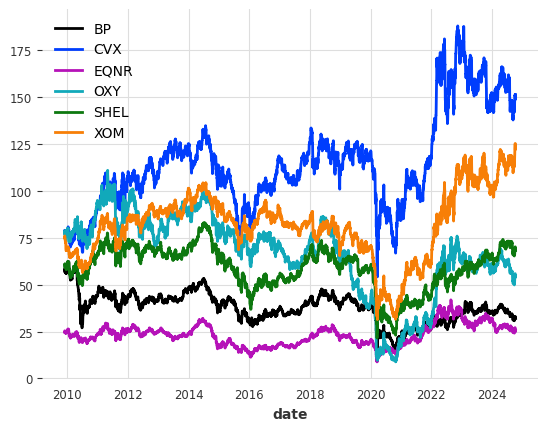

In [ ]:
from darts import TimeSeries

targets = TimeSeries.from_dataframe(
    data_wide['close'][['BP', 'CVX', 'EQNR', 'OXY', 'SHEL', 'XOM']],
    freq='D',
    )

targets.plot()

### Past Covariates TimeSeries

<Axes: xlabel='date'>

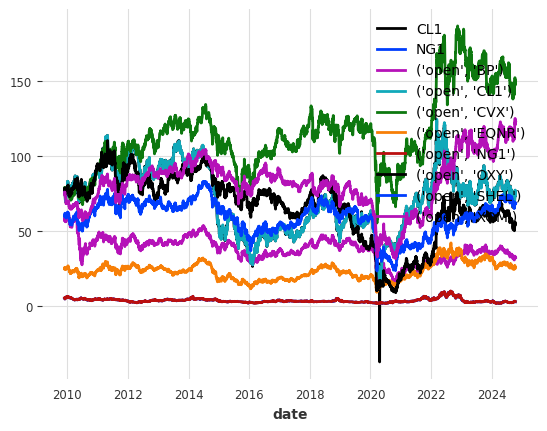

In [ ]:
from darts import concatenate

past_covariates_close = TimeSeries.from_dataframe(
    data_wide['close'][["CL1", "NG1"]],
    freq='D',
    )

past_covariates_remainder = TimeSeries.from_dataframe(
    data_wide[['open',
        'high',
        'low',
        'volume',
        'daily_variation',
        'daily_return',
        '7day_SMA',
        '7day_STD',
        '30day_SMA',
        '7day_WMA',
        '30day_WMA',
        '7day_EMA',
        '30day_EMA',
        'momentum',
        'MACD',
        'MACD_signal',
        'MACD_hist',
        'RSI',
        'slowk',
        'slowd']],
    freq='D',
    )

past_covariates = concatenate([past_covariates_close, past_covariates_remainder], axis=1)
past_covariates.plot()

## Splitting the data

### Splitting holdout test set

<Axes: xlabel='date'>

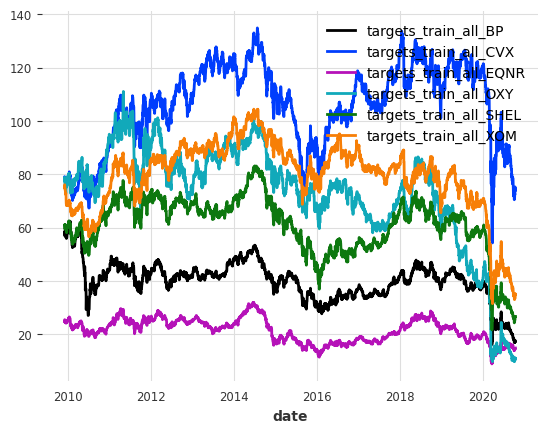

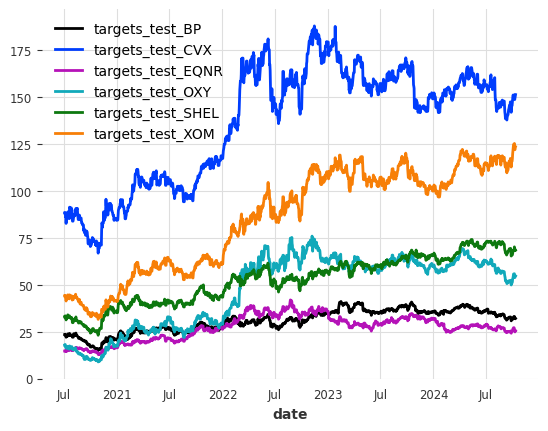

In [ ]:
from darts.utils.model_selection import train_test_split
test_size = 1461
input_size = 100
targets_train_all, targets_test = train_test_split(targets, test_size=test_size, axis=1, input_size=input_size, horizon=1, vertical_split_type="model-aware")
past_covariates_train_all, past_covariates_test = train_test_split(past_covariates, test_size=test_size, axis=1, input_size=input_size, horizon=1, vertical_split_type="model-aware")
targets_train_all.plot(label='targets_train_all')
targets_test.plot(new_plot=True, label='targets_test')

### Splitting train and validation sets

<Axes: xlabel='date'>

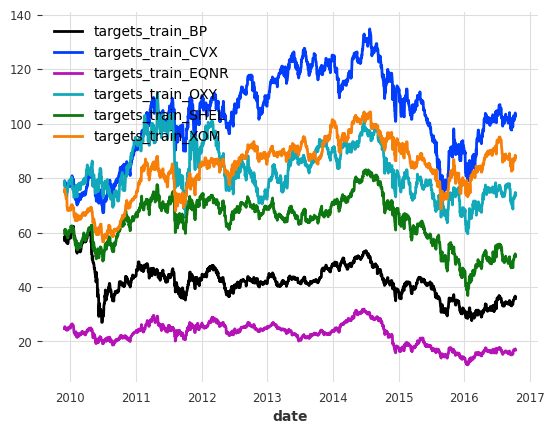

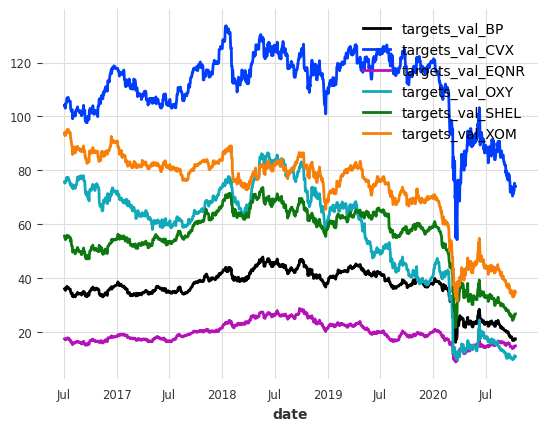

In [ ]:
targets_train, targets_val = train_test_split(targets_train_all, test_size=test_size, axis=1, input_size=input_size, horizon=1, vertical_split_type="model-aware")
past_covariates_train, past_covariates_val = train_test_split(past_covariates_train_all, test_size=test_size, axis=1, input_size=input_size, horizon=1, vertical_split_type="model-aware")
targets_train.plot(label='targets_train')
targets_val.plot(new_plot=True, label='targets_val')

## Preprocessing the train and validation sets

### Scaling entire train set and test set (for evaluation)

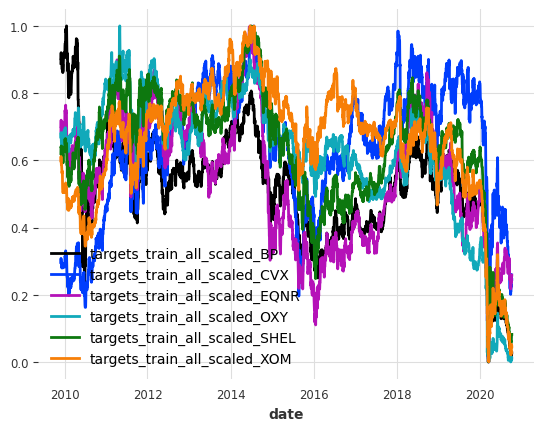

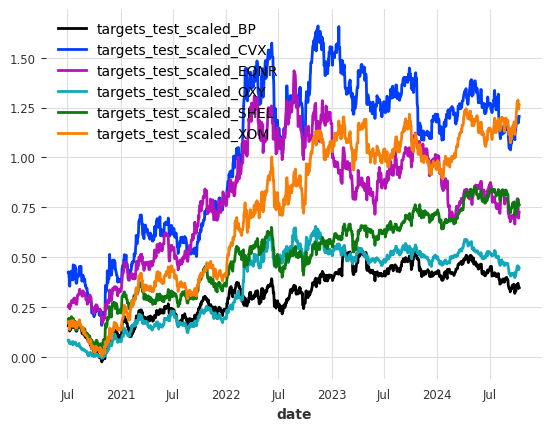

In [ ]:
from darts.dataprocessing.transformers.scaler import Scaler

targets_scaler_all = Scaler()
targets_train_all_scaled = targets_scaler_all.fit_transform(targets_train_all)
targets_test_scaled = targets_scaler_all.transform(targets_test)
targets_train_all_scaled.plot(new_plot=True, label='targets_train_all_scaled')
targets_test_scaled.plot(new_plot=True, label='targets_test_scaled')

past_covariates_scaler_all = Scaler()
past_covariates_train_all_scaled = past_covariates_scaler_all.fit_transform(past_covariates_train_all)
past_covariates_test_scaled = past_covariates_scaler_all.transform(past_covariates_test)

### Scaling train and validation sets

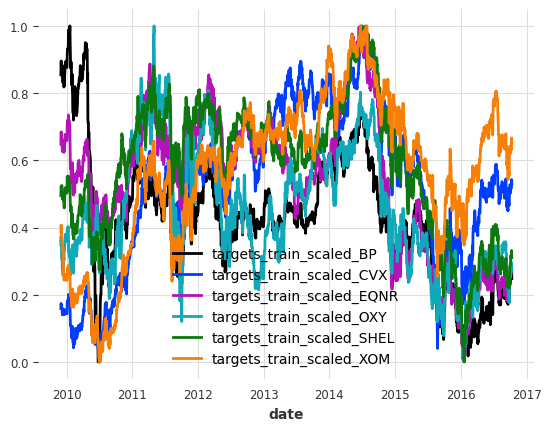

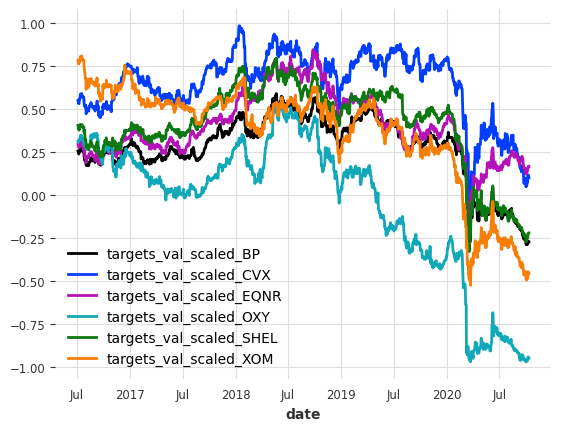

In [ ]:
targets_scaler = Scaler()
targets_train_scaled = targets_scaler.fit_transform(targets_train)
targets_val_scaled = targets_scaler.transform(targets_val)
targets_train_scaled.plot(new_plot=True, label='targets_train_scaled')
targets_val_scaled.plot(new_plot=True, label='targets_val_scaled')

past_covariates_scaler = Scaler()
past_covariates_train_scaled = past_covariates_scaler.fit_transform(past_covariates_train)
past_covariates_val_scaled = past_covariates_scaler.transform(past_covariates_val)

### Training models

#### TFT

In [ ]:
import torch
torch.set_float32_matmul_precision('high')

In [ ]:
import numpy as np
import optuna
from darts.metrics import mae
from darts.models import TFTModel
from pytorch_lightning.callbacks import EarlyStopping
import torch


def build_fit_tft_model(
        val_series,
        val_past_covariates,
        input_size=100,
        dropout=0.1,
        hidden_size=16,
):

    my_stopper = EarlyStopping(
        monitor="val_loss",
        patience=5,
        min_delta=0.01,
        mode='min',
    )
    pl_trainer_kwargs = {"callbacks": [my_stopper]}

    tft_model = TFTModel(
        model_name="tft",
        output_chunk_length=1,
        random_state=42,
        save_checkpoints=True,
        force_reset=True,
        full_attention=True,
        input_chunk_length=input_size,
        hidden_size=hidden_size,
        dropout=dropout,
        optimizer_kwargs={"lr": 1e-3},
        add_relative_index=True,
        add_encoders={
            "cyclic": {"future": ["day","month"]},
            'datetime_attribute': {'future': ['dayofweek', 'day', 'month', 'year']},
            'position': {'past': ['relative'], 'future': ['relative']},
            },
        pl_trainer_kwargs=pl_trainer_kwargs,
    )

    tft_model.fit(
        series=targets_train_scaled,
        past_covariates=past_covariates_train_scaled,
        val_series=val_series,
        val_past_covariates=val_past_covariates,
        verbose=False,
    )

    best_tft_model = tft_model.load_from_checkpoint(model_name='tft', best=True)
    return best_tft_model

def objective(trial):
    input_size = trial.suggest_int("input_size", 5, 205, step=10)
    dropout = trial.suggest_float("dropout", 0.1, 0.9, step=0.1)
    hidden_size = trial.suggest_int("hidden_size", 20, 320, step=20)

    # Resplit the validation set to account for the new input size
    _, targets_val = train_test_split(targets_train_all, test_size=test_size, axis=1, input_size=input_size, horizon=1, vertical_split_type="model-aware")
    _, past_covariates_val = train_test_split(past_covariates_train_all, test_size=test_size, axis=1, input_size=input_size, horizon=1, vertical_split_type="model-aware")

    # Scale the new validation set
    targets_val_scaled = targets_scaler.transform(targets_val)
    past_covariates_val_scaled = past_covariates_scaler.transform(past_covariates_val)

    best_tft_model = build_fit_tft_model(
        val_series=targets_val_scaled,
        val_past_covariates=past_covariates_val_scaled,
        input_size=input_size,
        dropout=dropout,
        hidden_size=hidden_size,
    )

    tft_targets_val_pred = best_tft_model.historical_forecasts(
        series=targets_val_scaled,
        past_covariates=past_covariates_val_scaled,
        forecast_horizon=1,
        stride=1,
        num_samples=5,
        retrain=False,
        last_points_only=True,
        verbose=False,
    )
    mae_val = mae(targets_scaler.inverse_transform(targets_val_scaled), targets_scaler.inverse_transform(tft_targets_val_pred))
    return mae_val if mae_val != np.nan else float("inf")

tft_study = optuna.create_study(direction="minimize", study_name="tft_study")
tft_study.optimize(objective, timeout=21600, n_jobs=1, show_progress_bar=True)
print(f"Best value: {tft_study.best_value}, Best params: {tft_study.best_trial.params}")

[I 2024-10-27 20:32:22,138] A new study created in memory with name: tft_study


   0%|          | 00:00/6:00:00

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unle

[I 2024-10-27 20:45:00,204] Trial 0 finished with value: 9.850214638341216 and parameters: {'input_size': 95, 'dropout': 0.9, 'hidden_size': 220}. Best is trial 0 with value: 9.850214638341216.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unle

[I 2024-10-27 20:55:54,379] Trial 1 finished with value: 8.93489251462069 and parameters: {'input_size': 65, 'dropout': 0.30000000000000004, 'hidden_size': 320}. Best is trial 1 with value: 8.93489251462069.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unle

[I 2024-10-27 21:01:19,769] Trial 2 finished with value: 10.419059890931583 and parameters: {'input_size': 15, 'dropout': 0.2, 'hidden_size': 220}. Best is trial 1 with value: 8.93489251462069.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unle

[I 2024-10-27 21:17:54,387] Trial 3 finished with value: 9.40610947620915 and parameters: {'input_size': 105, 'dropout': 0.9, 'hidden_size': 300}. Best is trial 1 with value: 8.93489251462069.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unle

[I 2024-10-27 21:35:34,301] Trial 4 finished with value: 9.826558003326596 and parameters: {'input_size': 155, 'dropout': 0.9, 'hidden_size': 160}. Best is trial 1 with value: 8.93489251462069.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unle

[I 2024-10-27 21:43:27,862] Trial 5 finished with value: 11.157651557134706 and parameters: {'input_size': 95, 'dropout': 0.6, 'hidden_size': 320}. Best is trial 1 with value: 8.93489251462069.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unle

[I 2024-10-27 21:51:55,180] Trial 6 finished with value: 10.040959125834732 and parameters: {'input_size': 145, 'dropout': 0.2, 'hidden_size': 20}. Best is trial 1 with value: 8.93489251462069.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unle

[I 2024-10-27 21:59:03,997] Trial 7 finished with value: 9.298016020948692 and parameters: {'input_size': 75, 'dropout': 0.30000000000000004, 'hidden_size': 240}. Best is trial 1 with value: 8.93489251462069.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unle

[I 2024-10-27 22:04:28,843] Trial 8 finished with value: 11.113411144445458 and parameters: {'input_size': 25, 'dropout': 0.6, 'hidden_size': 80}. Best is trial 1 with value: 8.93489251462069.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unle

[I 2024-10-27 22:09:18,684] Trial 9 finished with value: 9.142407501067522 and parameters: {'input_size': 15, 'dropout': 0.5, 'hidden_size': 320}. Best is trial 1 with value: 8.93489251462069.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unle

[I 2024-10-27 22:20:47,626] Trial 10 finished with value: 9.302255253962612 and parameters: {'input_size': 205, 'dropout': 0.4, 'hidden_size': 140}. Best is trial 1 with value: 8.93489251462069.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unle

[I 2024-10-27 22:27:00,218] Trial 11 finished with value: 9.160338386237116 and parameters: {'input_size': 45, 'dropout': 0.5, 'hidden_size': 280}. Best is trial 1 with value: 8.93489251462069.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unle

[I 2024-10-27 22:33:49,087] Trial 12 finished with value: 9.82784570930702 and parameters: {'input_size': 55, 'dropout': 0.1, 'hidden_size': 320}. Best is trial 1 with value: 8.93489251462069.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unle

[I 2024-10-27 22:41:15,218] Trial 13 finished with value: 8.495328958464789 and parameters: {'input_size': 5, 'dropout': 0.7000000000000001, 'hidden_size': 260}. Best is trial 13 with value: 8.495328958464789.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unle

[I 2024-10-27 22:53:55,174] Trial 14 finished with value: 8.362978764981568 and parameters: {'input_size': 55, 'dropout': 0.7000000000000001, 'hidden_size': 260}. Best is trial 14 with value: 8.362978764981568.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unle

[I 2024-10-27 23:03:49,234] Trial 15 finished with value: 8.84786553288224 and parameters: {'input_size': 5, 'dropout': 0.8, 'hidden_size': 260}. Best is trial 14 with value: 8.362978764981568.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unle

[I 2024-10-27 23:10:35,986] Trial 16 finished with value: 9.103870180353248 and parameters: {'input_size': 35, 'dropout': 0.7000000000000001, 'hidden_size': 180}. Best is trial 14 with value: 8.362978764981568.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unle

[I 2024-10-27 23:21:49,726] Trial 17 finished with value: 9.926578776955523 and parameters: {'input_size': 145, 'dropout': 0.7000000000000001, 'hidden_size': 200}. Best is trial 14 with value: 8.362978764981568.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unle

[I 2024-10-27 23:29:46,820] Trial 18 finished with value: 9.58231847405352 and parameters: {'input_size': 45, 'dropout': 0.7000000000000001, 'hidden_size': 120}. Best is trial 14 with value: 8.362978764981568.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unle

[I 2024-10-27 23:38:07,941] Trial 19 finished with value: 9.827797604020589 and parameters: {'input_size': 75, 'dropout': 0.8, 'hidden_size': 260}. Best is trial 14 with value: 8.362978764981568.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unle

[I 2024-10-27 23:56:44,341] Trial 20 finished with value: 8.50052105398611 and parameters: {'input_size': 115, 'dropout': 0.6, 'hidden_size': 280}. Best is trial 14 with value: 8.362978764981568.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unle

[I 2024-10-28 00:15:22,528] Trial 21 finished with value: 8.806003419987938 and parameters: {'input_size': 115, 'dropout': 0.6, 'hidden_size': 280}. Best is trial 14 with value: 8.362978764981568.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unle

[I 2024-10-28 00:25:15,030] Trial 22 finished with value: 10.669589984805894 and parameters: {'input_size': 125, 'dropout': 0.8, 'hidden_size': 240}. Best is trial 14 with value: 8.362978764981568.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unle

[I 2024-10-28 00:39:23,026] Trial 23 finished with value: 8.864783652699648 and parameters: {'input_size': 195, 'dropout': 0.6, 'hidden_size': 280}. Best is trial 14 with value: 8.362978764981568.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unle

[I 2024-10-28 00:45:35,695] Trial 24 finished with value: 8.71775968744416 and parameters: {'input_size': 85, 'dropout': 0.7000000000000001, 'hidden_size': 200}. Best is trial 14 with value: 8.362978764981568.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unle

[I 2024-10-28 00:54:57,401] Trial 25 finished with value: 9.055904967203384 and parameters: {'input_size': 5, 'dropout': 0.5, 'hidden_size': 240}. Best is trial 14 with value: 8.362978764981568.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unle

[I 2024-10-28 01:10:40,960] Trial 26 finished with value: 9.289832307627123 and parameters: {'input_size': 175, 'dropout': 0.8, 'hidden_size': 260}. Best is trial 14 with value: 8.362978764981568.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unle

[I 2024-10-28 01:15:41,152] Trial 27 finished with value: 9.118517127832321 and parameters: {'input_size': 35, 'dropout': 0.4, 'hidden_size': 300}. Best is trial 14 with value: 8.362978764981568.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unle

[I 2024-10-28 01:25:32,086] Trial 28 finished with value: 10.248321139700957 and parameters: {'input_size': 125, 'dropout': 0.7000000000000001, 'hidden_size': 200}. Best is trial 14 with value: 8.362978764981568.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unle

[I 2024-10-28 01:31:47,736] Trial 29 finished with value: 9.082231687732465 and parameters: {'input_size': 55, 'dropout': 0.5, 'hidden_size': 220}. Best is trial 14 with value: 8.362978764981568.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unle

[I 2024-10-28 01:37:30,076] Trial 30 finished with value: 10.338937879179863 and parameters: {'input_size': 95, 'dropout': 0.6, 'hidden_size': 100}. Best is trial 14 with value: 8.362978764981568.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unle

[I 2024-10-28 01:44:05,314] Trial 31 finished with value: 10.780601295847179 and parameters: {'input_size': 85, 'dropout': 0.7000000000000001, 'hidden_size': 180}. Best is trial 14 with value: 8.362978764981568.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unle

[I 2024-10-28 01:58:31,345] Trial 32 finished with value: 8.732394101275391 and parameters: {'input_size': 75, 'dropout': 0.7000000000000001, 'hidden_size': 220}. Best is trial 14 with value: 8.362978764981568.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unle

[I 2024-10-28 02:16:30,374] Trial 33 finished with value: 9.895462288857594 and parameters: {'input_size': 115, 'dropout': 0.8, 'hidden_size': 300}. Best is trial 14 with value: 8.362978764981568.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unle

[I 2024-10-28 02:23:22,230] Trial 34 finished with value: 10.097761075300303 and parameters: {'input_size': 55, 'dropout': 0.9, 'hidden_size': 200}. Best is trial 14 with value: 8.362978764981568.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unle

[I 2024-10-28 02:32:26,919] Trial 35 finished with value: 8.893934630651385 and parameters: {'input_size': 95, 'dropout': 0.6, 'hidden_size': 260}. Best is trial 14 with value: 8.362978764981568.
Best value: 8.362978764981568, Best params: {'input_size': 55, 'dropout': 0.7000000000000001, 'hidden_size': 260}


In [ ]:
print(f"Best value: {tft_study.best_value}, Best params: {tft_study.best_trial.params}")

from optuna.visualization import plot_optimization_history, plot_param_importances, plot_contour
plot_optimization_history(tft_study)

Best value: 8.362978764981568, Best params: {'input_size': 55, 'dropout': 0.7000000000000001, 'hidden_size': 260}


In [ ]:
plot_param_importances(tft_study)

In [ ]:
plot_contour(tft_study)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unl

Predicting: |          | 0/? [00:00<?, ?it/s]

10.124492


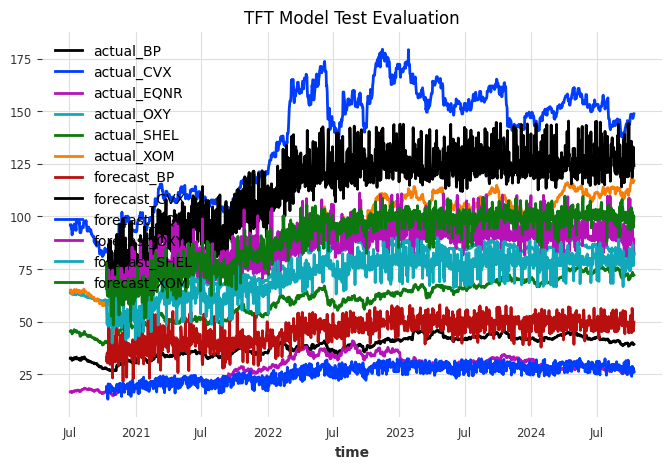

In [ ]:
import numpy as np
from darts.metrics import mae
from darts.models import TFTModel
from pytorch_lightning.callbacks import EarlyStopping

def get_tft_test_predictions(study=None):
    input_size = study.best_trial.params["input_size"]
    # Resplit the validation set to account for the new input size
    _, targets_val = train_test_split(targets_train_all, test_size=test_size, axis=1, input_size=input_size, horizon=1, vertical_split_type="model-aware")
    _, past_covariates_val = train_test_split(past_covariates_train_all, test_size=test_size, axis=1, input_size=input_size, horizon=1, vertical_split_type="model-aware")

    # Scale the new validation set
    targets_val_scaled = targets_scaler.transform(targets_val)
    past_covariates_val_scaled = past_covariates_scaler.transform(past_covariates_val)

    best_tft_model = build_fit_tft_model(
        val_series=targets_val_scaled,
        val_past_covariates=past_covariates_val_scaled,
        **study.best_trial.params
    )
    best_tft_model.save()

    # Resplit the test set to account for the new input size
    _, targets_test = train_test_split(targets, test_size=test_size, axis=1, input_size=input_size, horizon=1, vertical_split_type="model-aware")
    _, past_covariates_test = train_test_split(past_covariates, test_size=test_size, axis=1, input_size=input_size, horizon=1, vertical_split_type="model-aware")

    # Scale the new test set
    targets_test_scaled = targets_scaler_all.transform(targets_test)
    past_covariates_test_scaled = past_covariates_scaler_all.transform(past_covariates_test)

    tft_targets_pred = best_tft_model.historical_forecasts(
        series=targets_test_scaled,
        past_covariates=past_covariates_test_scaled,
        forecast_horizon=1,
        stride=1,
        num_samples=1,
        retrain=False,
        last_points_only=True,
        verbose=True,
    )
    return tft_targets_pred

tft_targets_pred = get_tft_test_predictions(tft_study)

plt.figure(figsize=(8, 5))
targets_scaler.inverse_transform(targets_test_scaled).plot(label='actual')
targets_scaler.inverse_transform(tft_targets_pred).plot(label='forecast')
plt.title('TFT Model Test Evaluation')
plt.legend()

print(mae(targets_scaler.inverse_transform(targets_test_scaled), targets_scaler.inverse_transform(tft_targets_pred)))

In [ ]:
# Assuming 'tft_targets_pred' contains the predictions from your TFT model
pred_df = targets_scaler.inverse_transform(tft_targets_pred).pd_dataframe()
pred_df.to_csv('tft_predictions.csv') # Changed file name for clarity

/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

Predicting: |          | 0/? [00:00<?, ?it/s]

9.909381009606012


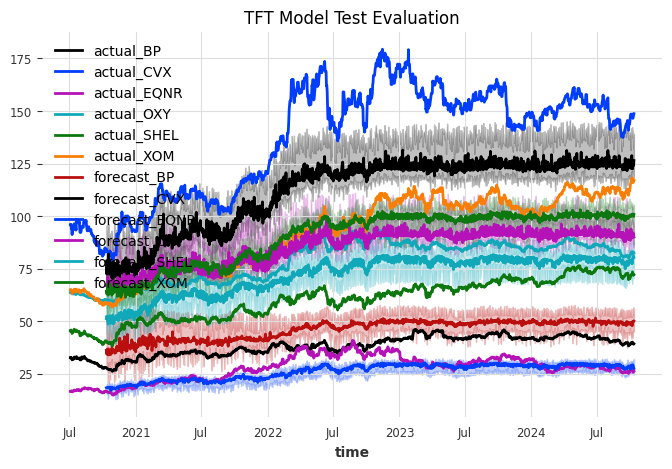

In [ ]:
import numpy as np
from darts.metrics import mae
from darts.models import TFTModel
from pytorch_lightning.callbacks import EarlyStopping

def get_tft_test_predictions_manual(input_size, best_tft_model):
    # # Resplit the validation set to account for the new input size
    # _, targets_val = train_test_split(targets_train_all, test_size=test_size, axis=1, input_size=input_size, horizon=1, vertical_split_type="model-aware")
    # _, past_covariates_val = train_test_split(past_covariates_train_all, test_size=test_size, axis=1, input_size=input_size, horizon=1, vertical_split_type="model-aware")

    # # Scale the new validation set
    # targets_val_scaled = targets_scaler.transform(targets_val)
    # past_covariates_val_scaled = past_covariates_scaler.transform(past_covariates_val)

    # best_tft_model = build_fit_tft_model(
    #     val_series=targets_val_scaled,
    #     val_past_covariates=past_covariates_val_scaled,
    #     **study.best_trial.params
    # )
    # best_tft_model.save()

    # Resplit the test set to account for the new input size
    _, targets_test = train_test_split(targets, test_size=test_size, axis=1, input_size=input_size, horizon=1, vertical_split_type="model-aware")
    _, past_covariates_test = train_test_split(past_covariates, test_size=test_size, axis=1, input_size=input_size, horizon=1, vertical_split_type="model-aware")

    # Scale the new test set
    targets_test_scaled = targets_scaler_all.transform(targets_test)
    past_covariates_test_scaled = past_covariates_scaler_all.transform(past_covariates_test)

    tft_targets_pred = best_tft_model.historical_forecasts(
        series=targets_test_scaled,
        past_covariates=past_covariates_test_scaled,
        forecast_horizon=1,
        stride=1,
        num_samples=20,
        retrain=False,
        last_points_only=True,
        verbose=True,
    )
    return tft_targets_pred

best_tft_model = TFTModel.load_from_checkpoint("tft")

tft_targets_pred = get_tft_test_predictions_manual(55, best_tft_model)

plt.figure(figsize=(8, 5))
targets_scaler.inverse_transform(targets_test_scaled).plot(label='actual')
targets_scaler.inverse_transform(tft_targets_pred).plot(label='forecast')
plt.title('TFT Model Test Evaluation')
plt.legend()

print(mae(targets_scaler.inverse_transform(targets_test_scaled), targets_scaler.inverse_transform(tft_targets_pred)))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

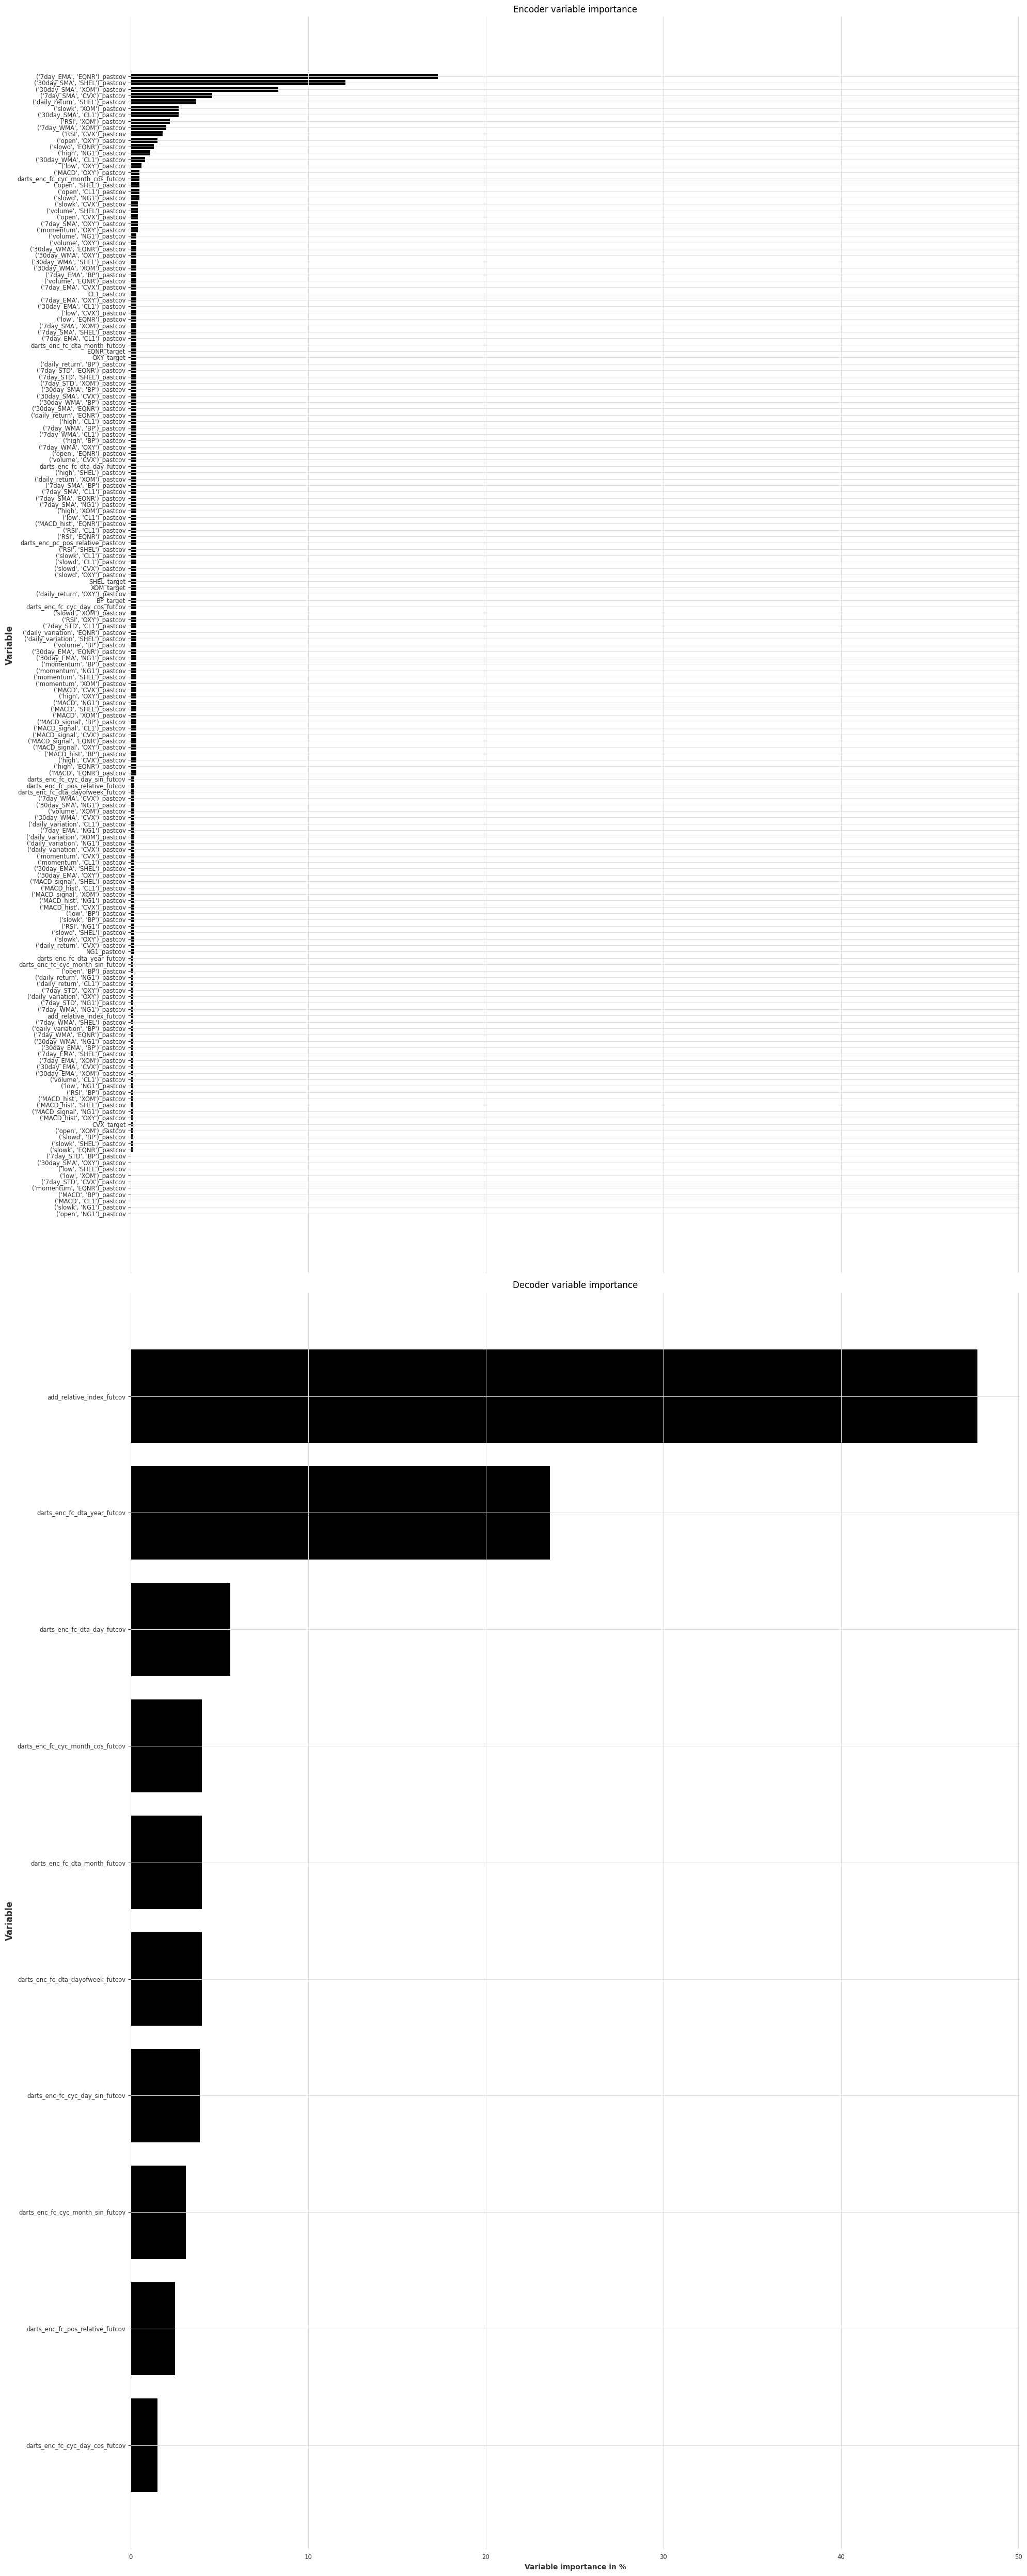

In [ ]:
from darts.explainability import TFTExplainer

explainer = TFTExplainer(best_tft_model)#, targets_train_scaled, past_covariates_train_scaled)
explainability_result = explainer.explain()
explainer.plot_variable_selection(explainability_result, fig_size=(20, 50), max_nr_series=6)

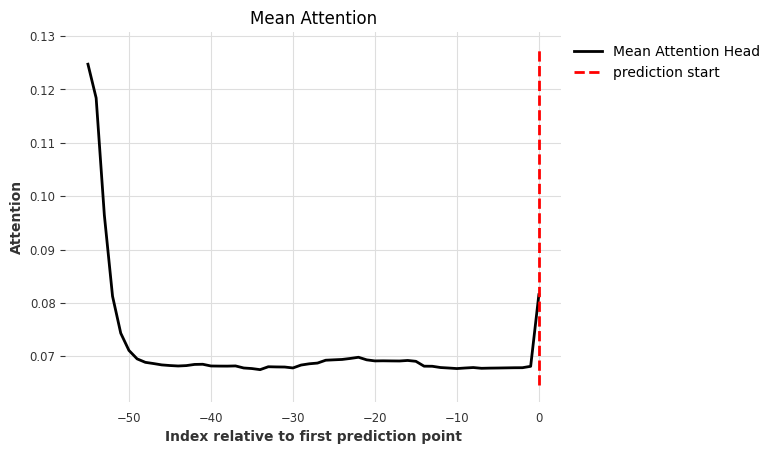

<Axes: title={'center': 'Mean Attention'}, xlabel='Index relative to first prediction point', ylabel='Attention'>

In [ ]:
explainer.plot_attention(explainability_result, plot_type="time")

In [ ]:
# Assuming 'tft_targets_pred' contains the predictions from your TFT model
pred_df = targets_scaler.inverse_transform(tft_targets_pred).quantile_df()
# Remove _ and after in the column names
pred_df.columns = [col.split('_')[0] for col in pred_df.columns]

pred_df.to_csv('tft_predictions.csv') # Changed file name for clarity